## Proyecto Final Redes Neuronales

- Martínez Cano Ricardo Iván 
- Victoria Morales Ricardo Maximiliano

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader    


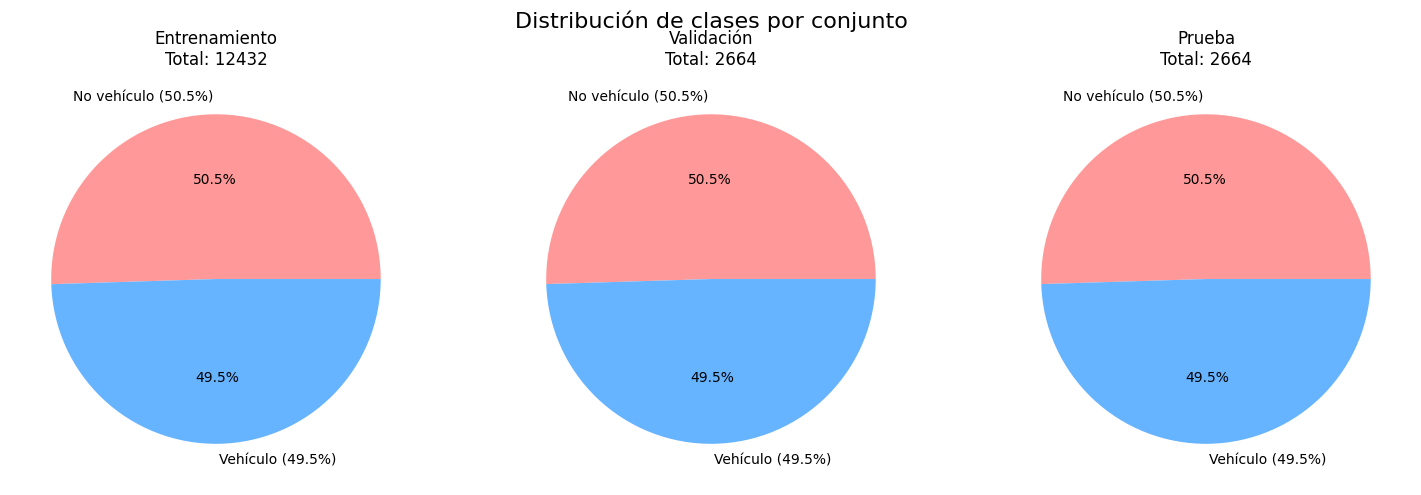

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
import os

# 1. Transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# 2. Cargar dataset
dataset = datasets.ImageFolder(root='data', transform=transform)
targets = np.array([label for _, label in dataset.samples])  # 0 o 1

# 3. División estratificada
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.3, stratify=targets, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=targets[temp_idx], random_state=42
)

# 4. Guardar índices
os.makedirs("splits", exist_ok=True)
np.save("splits/train_idx.npy", train_idx)
np.save("splits/val_idx.npy", val_idx)
np.save("splits/test_idx.npy", test_idx)

# 5. Subsets y DataLoaders
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Función de balance
def obtener_balance(loader):
    counts = torch.zeros(2)
    for _, labels in loader:
        for label in labels:
            counts[label.item()] += 1
    total = counts.sum().item()
    porcentajes = 100.0 * counts / total
    return counts.tolist(), porcentajes.tolist(), int(total)

# 7. Preparar visualización
clases = ['No vehículo', 'Vehículo']
conjuntos = ['Entrenamiento', 'Validación', 'Prueba']
loaders = [train_loader, val_loader, test_loader]
os.makedirs("plots", exist_ok=True)

# 8. Gráficas individuales con conteo total
for loader, nombre in zip(loaders, conjuntos):
    cuentas, porcentajes, total = obtener_balance(loader)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
           autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    ax.set_title(f"Distribución de clases - {nombre}")
    plt.suptitle(f"Total de imágenes: {total}", fontsize=10)
    plt.savefig(f"plots/{nombre.lower()}_distribution.png")
    plt.close()

# 9. Figura combinada con conteos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, loader in enumerate(loaders):
    cuentas, porcentajes, total = obtener_balance(loader)
    axes[i].pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
                autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    axes[i].set_title(f"{conjuntos[i]}\nTotal: {total}")

plt.suptitle("Distribución de clases por conjunto", fontsize=16)
plt.tight_layout()
plt.savefig("plots/combined_distribution.png")
plt.show()

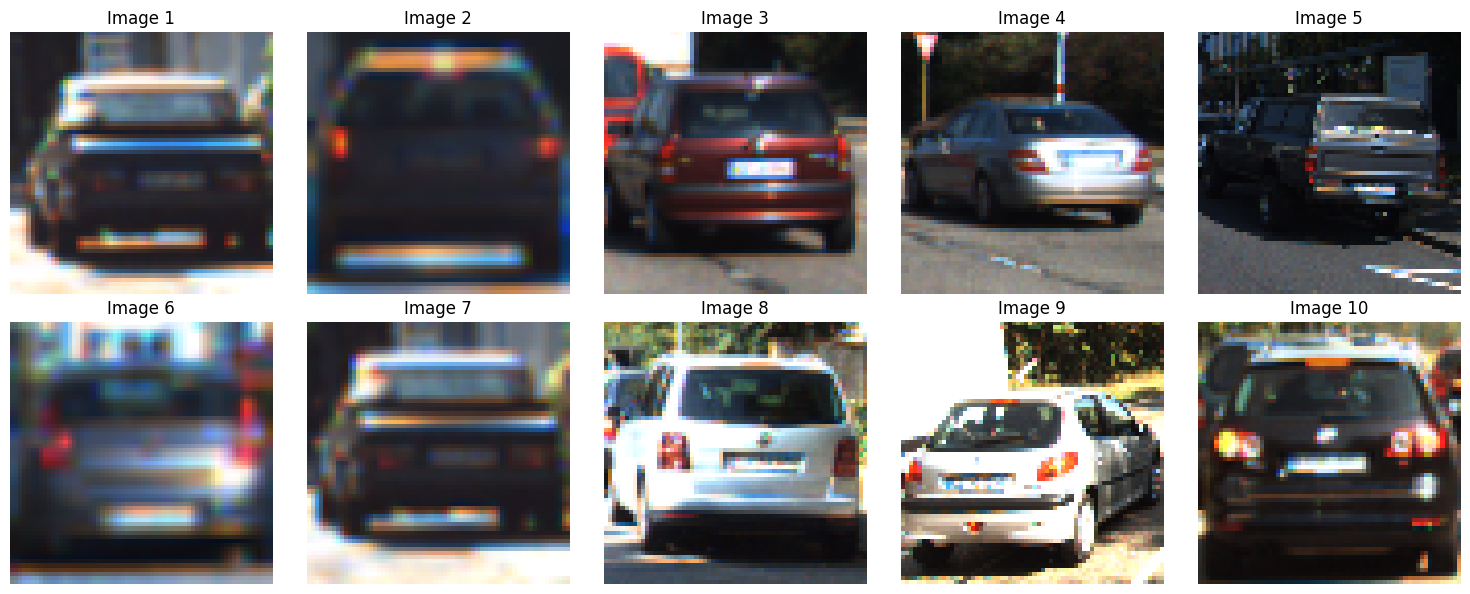

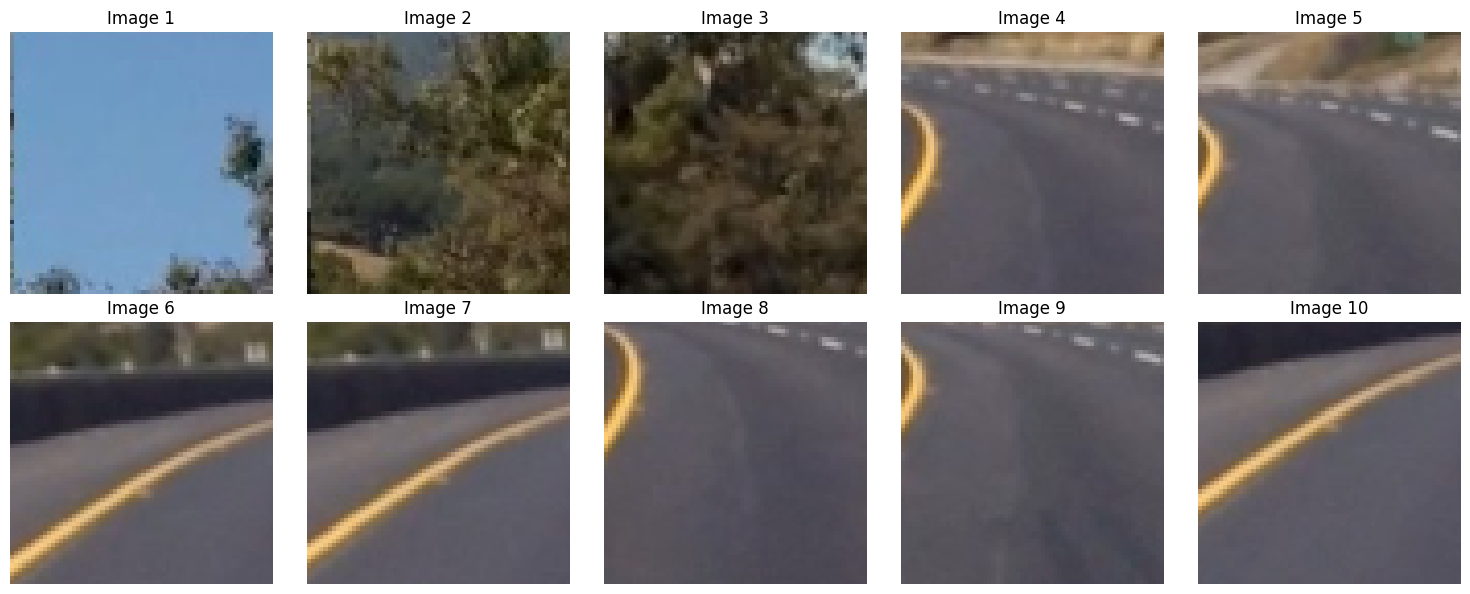

Total vehicle images: 8792
Total non-vehicle images: 8968


In [2]:
# Obtener directorios de datos
vehicle_dir = os.path.join(os.getcwd(), 'data', 'vehicles')
non_vehicle_dir = os.path.join(os.getcwd(), 'data', 'non-vehicles')
 
# Verificar si los directorios existen
if not os.path.exists(vehicle_dir):
    raise FileNotFoundError(f"Vehicle images directory does not exist: {vehicle_dir}")
if not os.path.exists(non_vehicle_dir):
    raise FileNotFoundError(f"Non-vehicle images directory does not exist: {non_vehicle_dir}")

def load_images(directory):
    """
    Carga imágenes de un directorio específico.
    """
    images = []
    for filename in glob.glob(os.path.join(directory, '*.png')):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
            images.append(img)
    return images

def display_images(images, ncols=5):
    """
    Muestra un conjunto de imágenes en una cuadrícula.
    """
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols  # Calcular número de filas
    fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 3 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for ax in axes:
        ax.axis('off')  # Ocultar ejes
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Cargar imágenes de vehículos y no vehículos
vehicle_images = load_images(vehicle_dir)
non_vehicle_images = load_images(non_vehicle_dir)

# Mostrar algunas imágenes de vehículos y no vehículos
display_images(vehicle_images[:10], ncols=5)
display_images(non_vehicle_images[:10], ncols=5)

# Verificar la cantidad de imágenes cargadas
print(f"Total vehicle images: {len(vehicle_images)}")
print(f"Total non-vehicle images: {len(non_vehicle_images)}")

In [3]:
# Transformar imagenes a tensores y normalizar

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VehicleDataset(Dataset):
    def __init__(self, vehicle_images, non_vehicle_images, transform=None):
        self.vehicle_images = vehicle_images
        self.non_vehicle_images = non_vehicle_images
        self.transform = transform
        self.labels = [1] * len(vehicle_images) + [0] * len(non_vehicle_images)
        self.images = vehicle_images + non_vehicle_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label 


# Crear dataset y dataloader
vehicle_dataset = VehicleDataset(vehicle_images, non_vehicle_images, transform=transform)
vehicle_dataloader = DataLoader(vehicle_dataset, batch_size=32, shuffle=True)

# Verificar el tamaño del dataset
print(f"Total dataset size: {len(vehicle_dataset)} images")

# Visualizar algunas imágenes transformadas
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    grid_img = tv.utils.make_grid(images, nrow=8)
    grid_img = grid_img / 2 + 0.5  # Desnormalizar para visualización 
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.title('Batch of Images')
    plt.axis('off')
    plt.show()

show_batch(vehicle_dataloader)



NameError: name 'vehicle_images' is not defined

In [4]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_input_size = 32 * 16 * 16  

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    

        x = x.view(-1, self.fc_input_size)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        return x
    


In [ ]:
def train_model(model, dataloader, epochs=10, learning_rate=0.001, cuda=False):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        model.train()
        print(f'Using device: {device}')
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Loss: {epoch_loss:.4f} '
              f'Accuracy: {epoch_acc:.2f}%')

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, train_accuracies
# Inicializar y entrenar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN()
cnn_model, training_losses = train_model(
    cnn_model,
    train_loader,
    epochs=10,
    learning_rate=0.001, 
    cuda=torch.cuda.is_available()
)



Starting epoch 1/10
Using device: cpu


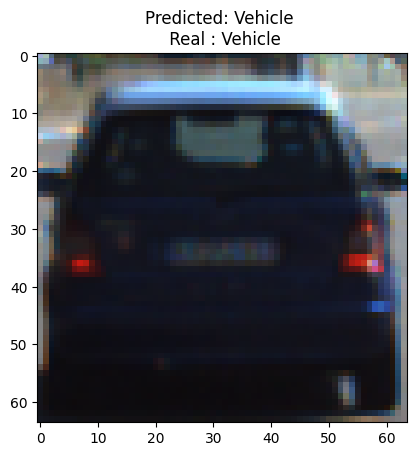

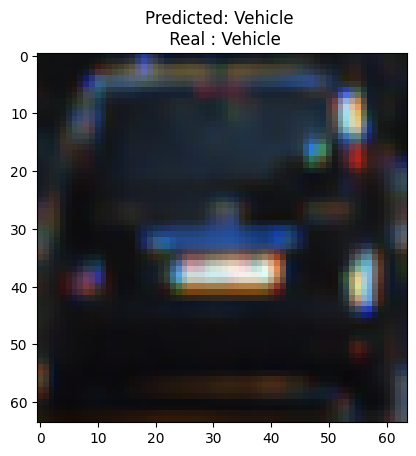

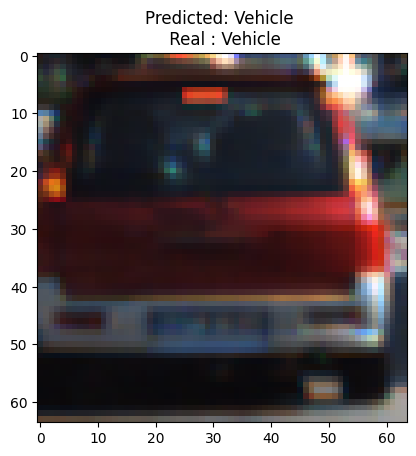

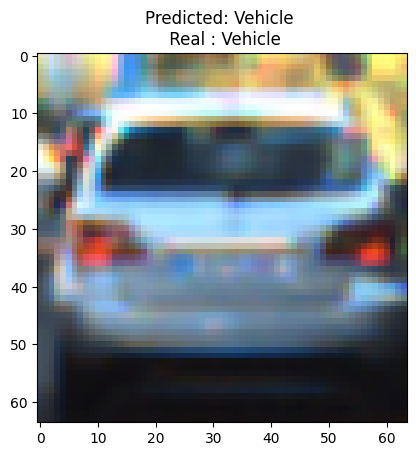

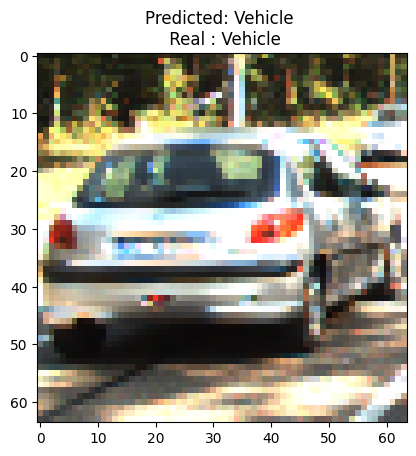

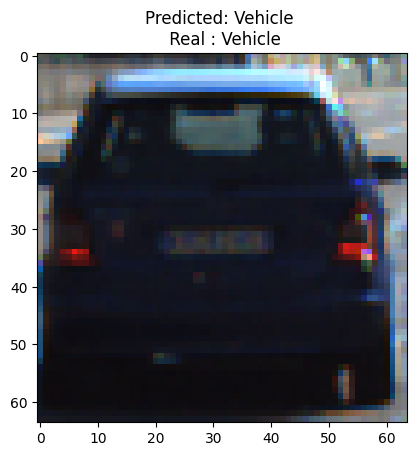

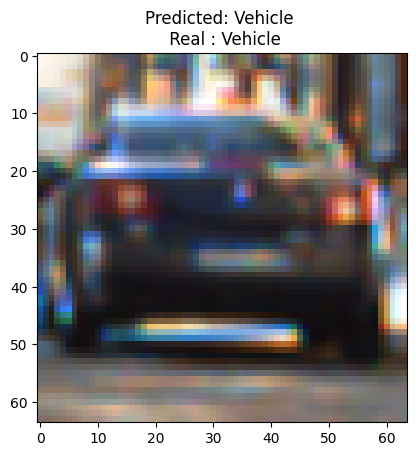

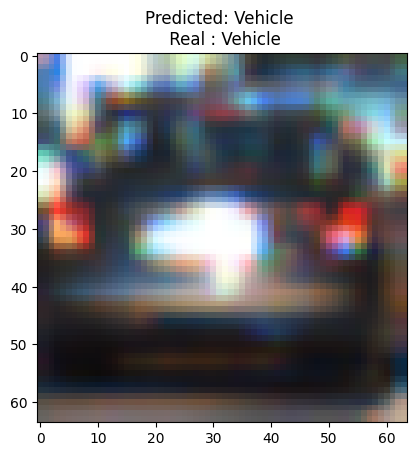

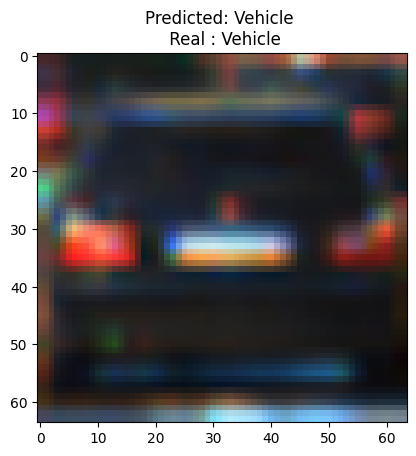

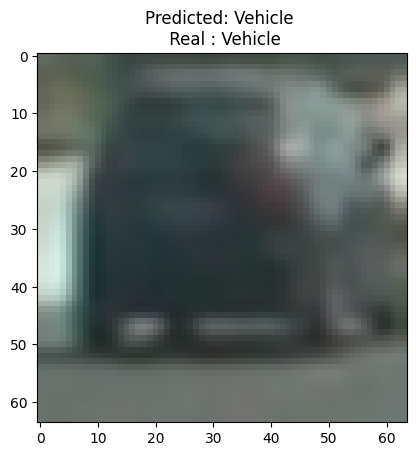

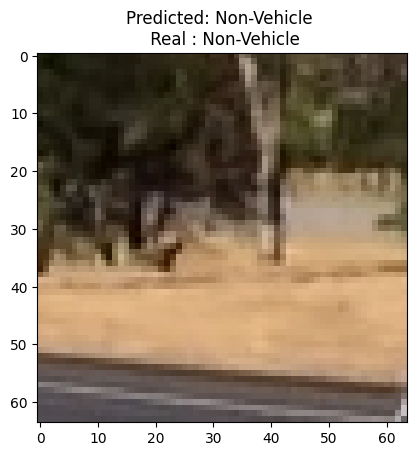

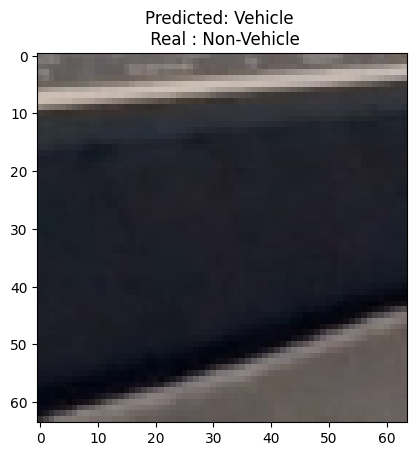

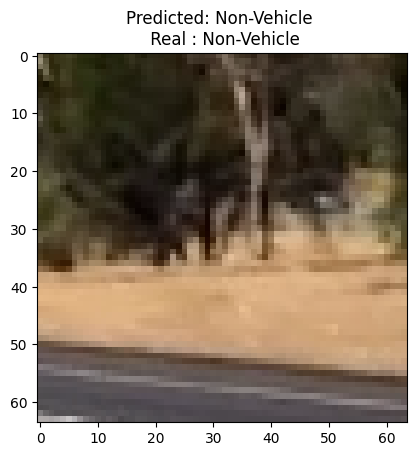

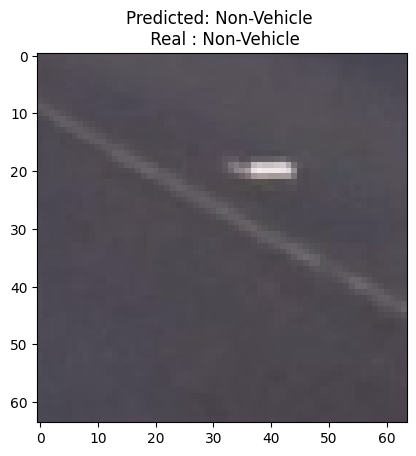

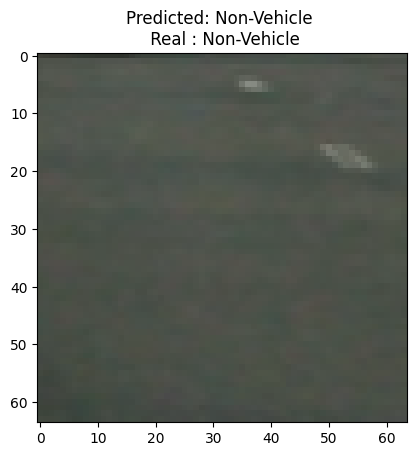

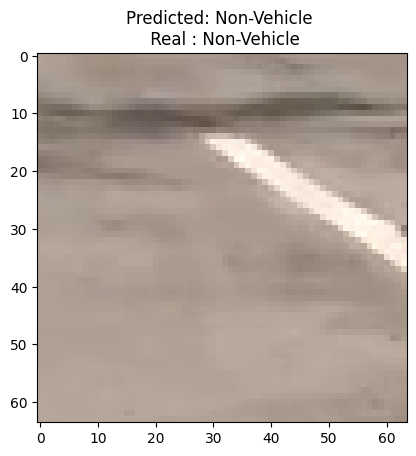

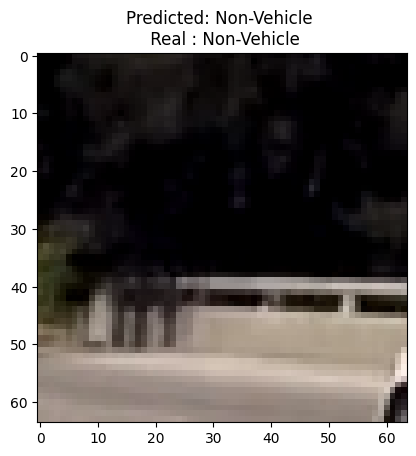

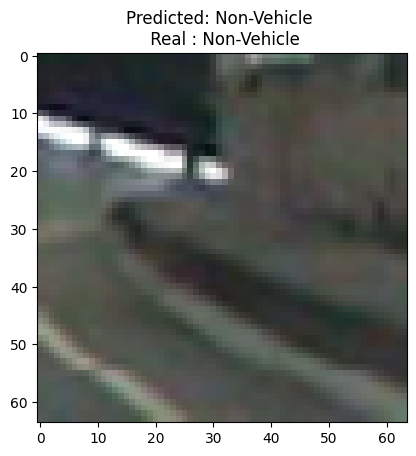

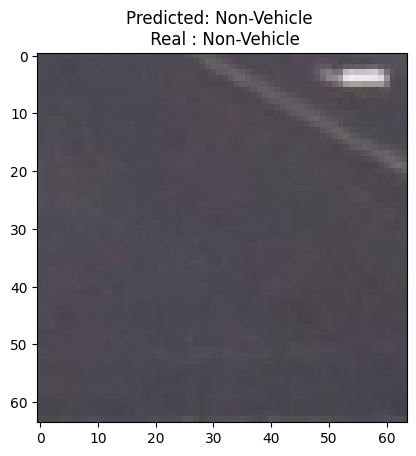

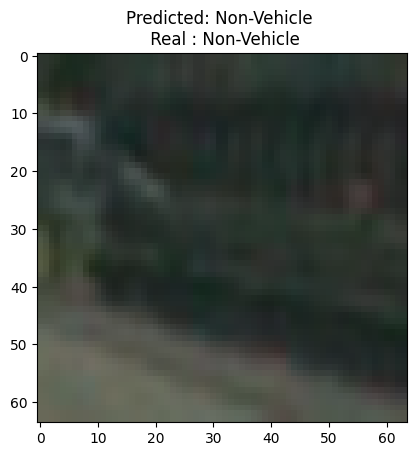

Predictions for test images:
Image 1: Vehicle
Image 2: Vehicle
Image 3: Vehicle
Image 4: Vehicle
Image 5: Vehicle
Image 6: Vehicle
Image 7: Vehicle
Image 8: Vehicle
Image 9: Vehicle
Image 10: Vehicle
Image 11: Non-Vehicle
Image 12: Vehicle
Image 13: Non-Vehicle
Image 14: Non-Vehicle
Image 15: Non-Vehicle
Image 16: Non-Vehicle
Image 17: Non-Vehicle
Image 18: Non-Vehicle
Image 19: Non-Vehicle
Image 20: Non-Vehicle


In [ ]:
# Probar el modelo con un ejemplo de imagen
def test_model(model, image, transform=None):
    model.eval()
    if transform:
        image = transform(image).unsqueeze(0)  # Añadir dimensión de batch
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

# Probar el modelo con diez imagenes de vehículos y no vehículos aleatorios

vehicle_images = random.sample(vehicle_images, 10)
non_vehicle_images = random.sample(non_vehicle_images, 10)
test_images = vehicle_images + non_vehicle_images
# Mezclar las imágenes de prueba
# random.shuffle(test_images)
# Realizar predicciones
predictions = []
for img in test_images:
    pred = test_model(cnn_model, img, transform=transform)
    predictions.append(pred)
# Mostrar resultados de las predicciones
for i, img in enumerate(test_images):
    plt.imshow(img)
    plt.title(f'Predicted: {"Vehicle" if predictions[i] == 1 else "Non-Vehicle"} \n Real : {"Vehicle" if i < 10 else "Non-Vehicle"}')
    plt.show()
# Mostrar las predicciones
print("Predictions for test images:")
for i, pred in enumerate(predictions):
    print(f"Image {i+1}: {'Vehicle' if pred == 1 else 'Non-Vehicle'}")

